In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [4]:
covertype_df = pd.read_csv('/users/linggeli/downloads/covtype.csv')

In [5]:
print(covertype_df.shape)

(581012, 55)


In [6]:
covertype_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
covertype_subset = covertype_df.iloc[0:500000:100, :]
print(covertype_subset.shape)

(5000, 55)


In [8]:
from sklearn.decomposition import PCA

In [9]:
X = covertype_subset.iloc[:, 0:54].values 
y = covertype_subset.iloc[:, 54].values
print(X.shape)
print(y.shape)

(5000, 54)
(5000,)


In [10]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)    

In [13]:
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.07462831 0.05784208]


In [14]:
scores = pca.transform(X)
print(scores.shape)

(5000, 2)


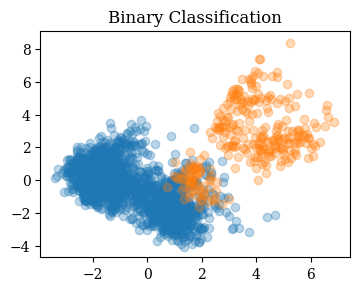

In [17]:
fig = plt.figure(figsize=(4, 3), dpi=100)
for i in [1, 3]:
    plt.scatter(scores[covertype_subset['Cover_Type'].values == i, 0], 
                scores[covertype_subset['Cover_Type'].values == i, 1], alpha=0.3)
plt.title('Binary Classification')
plt.show()

### Let's start with the simplest model, which is k-nearest neighbors.

In [18]:
def knn(x_instance, X_all, y_label, k):
    # calculate pairwise distance between x_instance and every row of X_all
    n = X_all.shape[0]
    x_stack = np.stack([x_instance] * n)
    distance = np.sum((X_all - x_stack) ** 2, axis=1)
    k_indices = np.argsort(distance)[1:(k + 1)]
    return y_label[k_indices]

### *Exercise 4. Explain what each line of the code does.*

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
select = (covertype_subset['Cover_Type'].values == 1) | (covertype_subset['Cover_Type'].values == 3)
X_train = scores[select]
y_train = y[select]

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
yhat = knn.predict(X_train)

### We can visualize what the model is doing by plotting the decision boundary in two dimensions. k-NN is a non-parametric model, as the decision boundary does not have a specific analytical form. Machine learning models tend to be more non-parametric, thus having greater flexibility when data are abundant.

https://stats.stackexchange.com/questions/230044/what-are-real-life-examples-of-non-parametric-statistical-models

In [23]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)

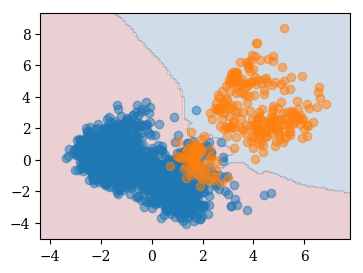

In [24]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.2)
for i in [1, 3]:
    plt.scatter(scores[covertype_subset['Cover_Type'].values == i, 0], 
                scores[covertype_subset['Cover_Type'].values == i, 1], alpha=0.5)
plt.show()

### To evaluate the model, we can just look at binary classification accuracy. Beyond that, there is a more informative metric based on the ROC curve.

In [25]:
from sklearn.metrics import roc_curve, auc

In [26]:
y_train[y_train == 3] = 0
yhat[yhat == 3] = 0

In [27]:
fpr, tpr, _ = roc_curve(yhat, y_train)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9630210573363355


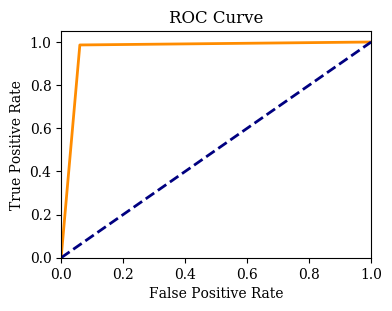

In [29]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### *Exercise 5. In what scenarios would accuracy be a terrible measure by itself?* 

### By using k-NN, we'd see the phenomenon known as *curse of dimensionality* in machine learning.

In [33]:
d = 100
X_cube = np.random.uniform(0, 1, [500, d])
x_instance = np.zeros(d)
X_all = X_cube
n = X_all.shape[0]
x_stack = np.stack([x_instance] * n)
distance = np.sqrt(np.sum((X_all - x_stack) ** 2, axis=1))

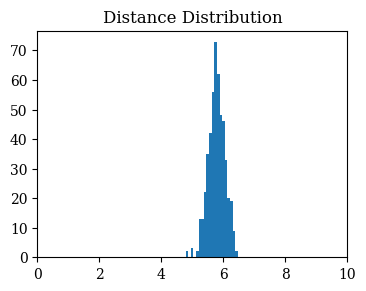

In [47]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.hist(distance, bins=20)
plt.xlim(0, np.sqrt(d))
plt.title('Distance Distribution')
plt.show()

### *Exercise 6. What does this imply for k-NN as the dimensionality increases with fixed sample size?*

### On the other hand, logistic regression is a simple parametric model that essentially tries to separate data of different classes with (hyper) planes.

https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://en.wikipedia.org/wiki/Logistic_regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
clf = LogisticRegression().fit(X_train, y_train)

In [41]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)

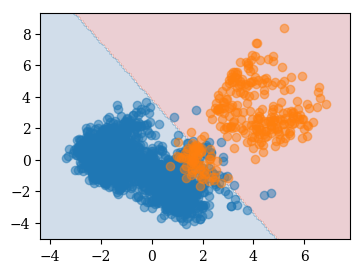

In [42]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.2)
for i in [1, 3]:
    plt.scatter(scores[covertype_subset['Cover_Type'].values == i, 0], 
                scores[covertype_subset['Cover_Type'].values == i, 1], alpha=0.5)
plt.show()

In [43]:
yhat = clf.predict(X_train)
yhat[yhat == 3] = 0

In [44]:
fpr, tpr, _ = roc_curve(yhat, y_train)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9457150175644028


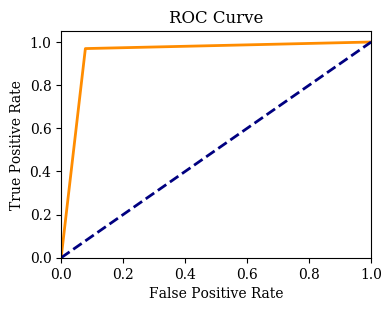

In [46]:
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Loss function and gradient descent.

https://www.youtube.com/watch?v=z_xiwjEdAC4

https://www.youtube.com/watch?v=_-02ze7tf08

### *Exercise 7. Interpret the regression coefficients.*

In [50]:
print(clf.coef_)

[[-1.88851238 -1.04653414]]


### *Exercise 8. Try multinomial logistic regression.*

https://www.youtube.com/watch?v=mlaLLQofmR8

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py